In [27]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from pandas.tseries.offsets import DateOffset
import geopandas as gpd
from shapely.geometry import Polygon


## National Results

In [28]:

national_results = pd.read_csv('data_tables/national_results.csv')

#Convert release period to datetime
national_results['Release Period'] = pd.to_datetime(national_results['Release Period'].str.lstrip('07_'))
national_results.columns = national_results.columns.str.lower().str.replace(' ', '_')
national_results['nps'] = national_results['top-box_percentage'] - national_results['bottom-box_percentage']

national_results

,release_period,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage,nps
0,2015-01-01,H_CLEAN_HSP,8,18,74,66
1,2015-01-01,H_COMP_1,4,17,79,75
2,2015-01-01,H_COMP_2,4,14,82,78
3,2015-01-01,H_COMP_3,9,23,68,59
4,2015-01-01,H_COMP_5,18,17,65,47
...,...,...,...,...,...,...
85,2023-01-01,H_COMP_6,14,0,86,72
86,2023-01-01,H_COMP_7,6,43,51,45
87,2023-01-01,H_HSP_RATING,9,21,70,61
88,2023-01-01,H_QUIET_HSP,10,28,62,52


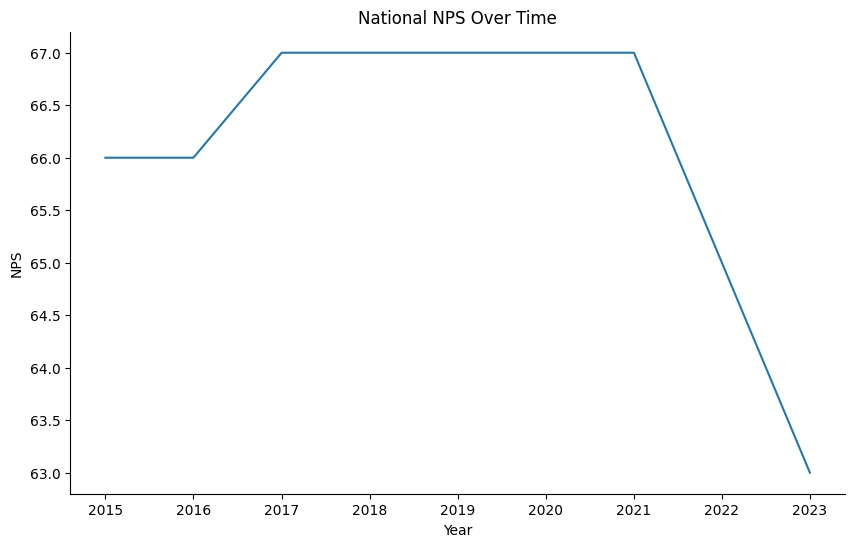

In [6]:
# National NPS over time
national_nps = national_results[national_results['measure_id'] == 'H_RECMND']
plt.figure(figsize=(10, 6))
ax = sns.lineplot(national_nps, x='release_period', y='nps')
plt.title('National NPS Over Time')
plt.xlabel('Year')
plt.ylabel('NPS')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

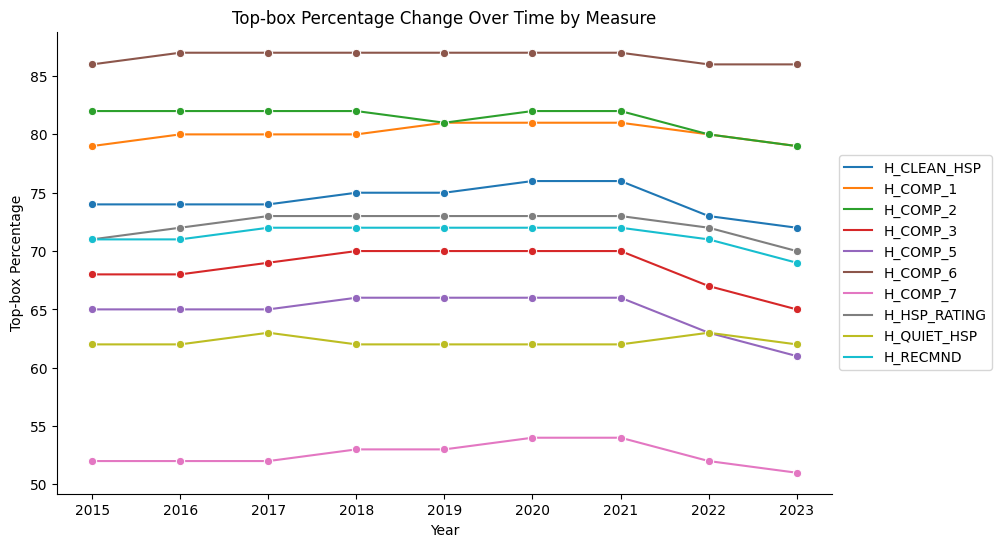

In [7]:
# Top-box percentage change over time by measure
plt.figure(figsize=(10, 6))
ax = sns.lineplot(national_results, x='release_period', y='top-box_percentage', hue='measure_id', marker='o')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Top-box Percentage Change Over Time by Measure')
plt.xlabel('Year')
plt.ylabel('Top-box Percentage')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

<Figure size 1000x600 with 0 Axes>

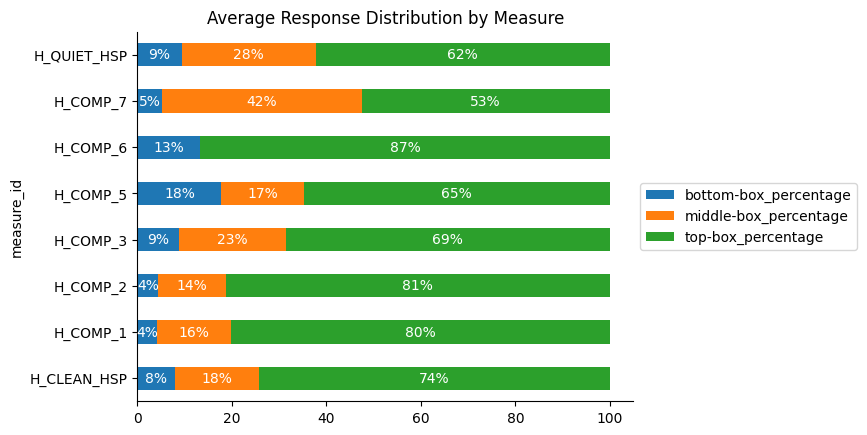

In [9]:

average_national_results = national_results.drop(columns=['release_period', 'nps']).groupby('measure_id').mean().reset_index()
average_national_results = average_national_results[~average_national_results['measure_id'].isin(['H_RECMND', 'H_HSP_RATING'])]
average_national_results

# Average response distribution by measure
plt.figure(figsize=(10, 6))
ax = average_national_results.plot(kind='barh', x='measure_id', stacked=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average Response Distribution by Measure')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Annotate the bars
for p in ax.patches:
    width = p.get_width()
    if width > 0:  # To avoid annotating bars with 0 width
        ax.text(width/2 + p.get_x(), 
                p.get_y() + p.get_height()/2, 
                '{:.0f}%'.format(width), 
                ha='center', 
                va='center', 
                color='white')

plt.show()

## Responses

remove 5 unincorporated territories
remove rows with data not available
average national response rate by year
2015 all not available

In [85]:
# state_results = pd.read_csv('data_tables/state_results.csv')
# national_results['Release Period'] = pd.to_datetime(national_results['Release Period'].str.lstrip('07_'))
# national_results.columns = national_results.columns.str.lower().str.replace(' ', '_')
responses = pd.read_csv('data_tables/responses.csv')
responses['Release Period'] = pd.to_datetime(responses['Release Period'].str.lstrip('07_')).dt.year

responses.columns = responses.columns.str.lower().str.replace(' ', '_')
responses.rename(columns={'response_rate_(%)': 'response_rate'}, inplace=True)

responses

,release_period,state,facility_id,completed_surveys,response_rate
0,2015,AL,10001,300 or more,27
1,2015,AL,10005,300 or more,37
2,2015,AL,10006,300 or more,25
3,2015,AL,10007,Between 100 and 299,30
4,2015,AL,10008,Fewer than 100,28
...,...,...,...,...,...
43214,2023,TX,670300,186,15
43215,2023,TX,670309,164,12
43216,2023,TX,670310,Not Available,Not Available
43217,2023,TX,670314,Not Available,Not Available


In [98]:
states = pd.read_csv('data_tables/states.csv')
states.columns = states.columns.str.lower().str.replace(' ', '_')

responses[~responses['state'].isin(states['state'])].state.value_counts()

responses = responses[responses['state'].isin(states['state'])]
responses


,release_period,state,facility_id,completed_surveys,response_rate
0,2015,AL,10001,300 or more,27
1,2015,AL,10005,300 or more,37
2,2015,AL,10006,300 or more,25
3,2015,AL,10007,Between 100 and 299,30
4,2015,AL,10008,Fewer than 100,28
...,...,...,...,...,...
43214,2023,TX,670300,186,15
43215,2023,TX,670309,164,12
43216,2023,TX,670310,Not Available,Not Available
43217,2023,TX,670314,Not Available,Not Available


In [117]:
def interpolate(df, col):
    df1 = df.copy()
    df

interpolate(6, 4)

10

In [134]:
response_count = responses.groupby(['release_period', 'state'])['facility_id'].count().reset_index(name='count')
# # Interpolate missing MD 2016 data
# # New dataframes for MD 2015 and 2017 data
# df = response_count.copy()
# md_2015 = df[(df.state == 'MD') & (df.release_period == 2015)]
# md_2017 = df[(df.state == 'MD') & (df.release_period == 2017)]

# # Interpolate 2016 data using average of 2015 and 2017 data
# md_inter = md_2015.copy()
# for col in ['bottom-box_percentage', 'middle-box_percentage', 'top-box_percentage']:
#     md_inter[col] = (md_2015[col].values + md_2017[col].values) / 2
# md_inter['release_period'] = md_inter['release_period'] + DateOffset(years=1)

# # Concatenate interpolated data with original dataframe
# response_count = pd.concat([response_count, md_inter], ignore_index=True)
response_count

,release_period,state,count
0,2015,AK,21
1,2015,AL,88
2,2015,AR,75
3,2015,AZ,76
4,2015,CA,334
...,...,...,...
454,2023,VT,15
455,2023,WA,94
456,2023,WI,130
457,2023,WV,50


In [121]:
response_count[response_count['state'] == 'MD']

,release_period,state,count
20,2015,MD,44
71,2016,MD,46
122,2017,MD,49
173,2018,MD,49
224,2019,MD,51
275,2020,MD,52
326,2021,MD,52
377,2022,MD,50
428,2023,MD,49


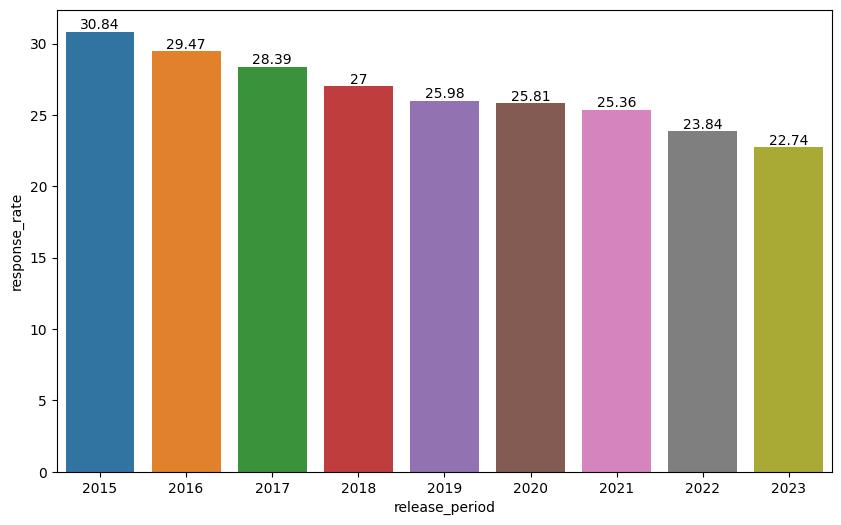

In [99]:
rr = responses[responses.response_rate != 'Not Available'].copy()
# rr.loc[:, 'response_rate'] = pd.to_numeric(rr.response_rate)
rr.response_rate = rr.response_rate.astype('int64')
national_rr = rr.groupby('release_period')[['response_rate']].mean().round(2).reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(national_rr, x='release_period', y='response_rate')
for label in ax.containers:
    ax.bar_label(label)
plt.show()


In [125]:
response_count = responses.groupby(['release_period', 'state'])['facility_id'].count().reset_index()
response_count

,release_period,state,facility_id
0,2015,AK,21
1,2015,AL,88
2,2015,AR,75
3,2015,AZ,76
4,2015,CA,334
...,...,...,...
454,2023,VT,15
455,2023,WA,94
456,2023,WI,130
457,2023,WV,50


## State

In [126]:
# 
state_results = pd.read_csv('data_tables/state_results.csv')
# state_results = dataframes['state_results']
state_results['Release Period'] = pd.to_datetime(state_results['Release Period'].str.lstrip('07_')).dt.year
state_results.columns = state_results.columns.str.lower().str.replace(' ', '_')
state_results

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage
0,2015,AK,H_CLEAN_HSP,8,22,70
1,2015,AK,H_COMP_1,9,17,74
2,2015,AK,H_COMP_2,10,15,75
3,2015,AK,H_COMP_3,11,21,68
4,2015,AK,H_COMP_5,19,17,64
...,...,...,...,...,...,...
4575,2023,WY,H_COMP_6,14,0,86
4576,2023,WY,H_COMP_7,5,41,54
4577,2023,WY,H_HSP_RATING,7,22,71
4578,2023,WY,H_QUIET_HSP,6,28,66


In [128]:
# Interpolate missing MD 2016 data
# New dataframes for MD 2015 and 2017 data
df = state_results.copy()
md_2015 = df[(df.state == 'MD') & (df.release_period == 2015)]
md_2017 = df[(df.state == 'MD') & (df.release_period == 2017)]

# Interpolate 2016 data using average of 2015 and 2017 data
md_inter = md_2015.copy()
for col in ['bottom-box_percentage', 'middle-box_percentage', 'top-box_percentage']:
    md_inter[col] = (md_2015[col].values + md_2017[col].values) / 2
md_inter['release_period'] = md_inter['release_period'] + 1

# Concatenate interpolated data with original dataframe
state_results = pd.concat([state_results, md_inter], ignore_index=True)
state_results

,release_period,state,measure_id,bottom-box_percentage,middle-box_percentage,top-box_percentage
0,2015,AK,H_CLEAN_HSP,8.0,22.0,70.0
1,2015,AK,H_COMP_1,9.0,17.0,74.0
2,2015,AK,H_COMP_2,10.0,15.0,75.0
3,2015,AK,H_COMP_3,11.0,21.0,68.0
4,2015,AK,H_COMP_5,19.0,17.0,64.0
...,...,...,...,...,...,...
4585,2016,MD,H_COMP_6,14.0,0.0,86.0
4586,2016,MD,H_COMP_7,7.0,45.0,48.0
4587,2016,MD,H_HSP_RATING,10.0,25.0,65.0
4588,2016,MD,H_QUIET_HSP,12.0,30.5,57.5


In [135]:
state_results['nps'] = state_results['top-box_percentage'] - state_results['bottom-box_percentage']
state_nps = state_results.groupby(['release_period', 'state'])['nps'].mean().reset_index()
state_nps_count = state_nps.merge(response_count, on=['release_period', 'state'], how='left')
state_nps_count

,release_period,state,nps,count
0,2015,AK,57.0,21
1,2015,AL,64.4,88
2,2015,AR,62.3,75
3,2015,AZ,59.9,76
4,2015,CA,56.2,334
...,...,...,...,...
454,2023,VT,61.8,15
455,2023,WA,59.1,94
456,2023,WI,65.9,130
457,2023,WV,59.4,50


In [158]:
state_df.avg_count.std()

74.12960981479748

In [156]:
state_df.sort_values(by='avg_nps', ascending=True)

,state,avg_nps,avg_count
7,DC,47.88,8.11
31,NJ,54.06,65.89
20,MD,55.02,49.11
34,NY,55.08,170.89
33,NV,55.17,36.44
9,FL,56.14,186.67
4,CA,56.24,341.11
3,AZ,58.23,79.78
32,NM,58.66,42.22
6,CT,59.14,30.89


In [143]:
state_df = state_nps_count.groupby(['state']).agg(avg_nps=('nps', 'mean'), avg_count=('count', 'mean')).reset_index().round(2)

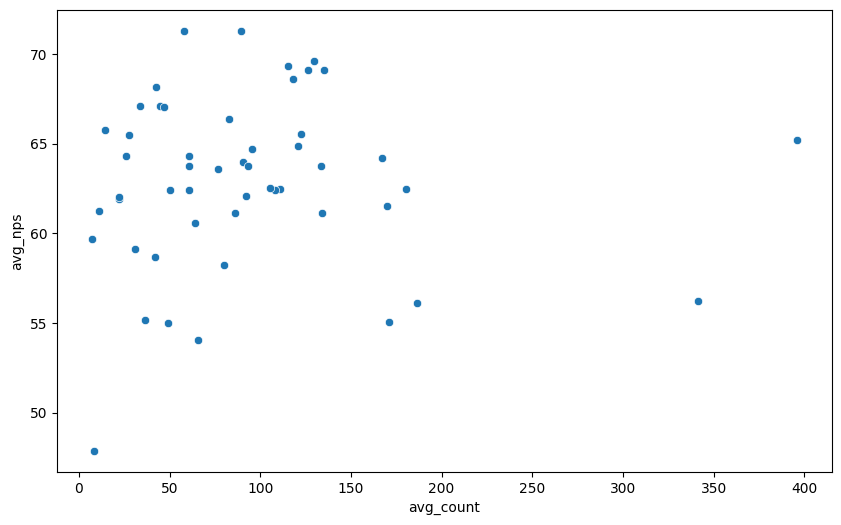

In [147]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(state_df, x='avg_count', y='avg_nps')
plt.show()

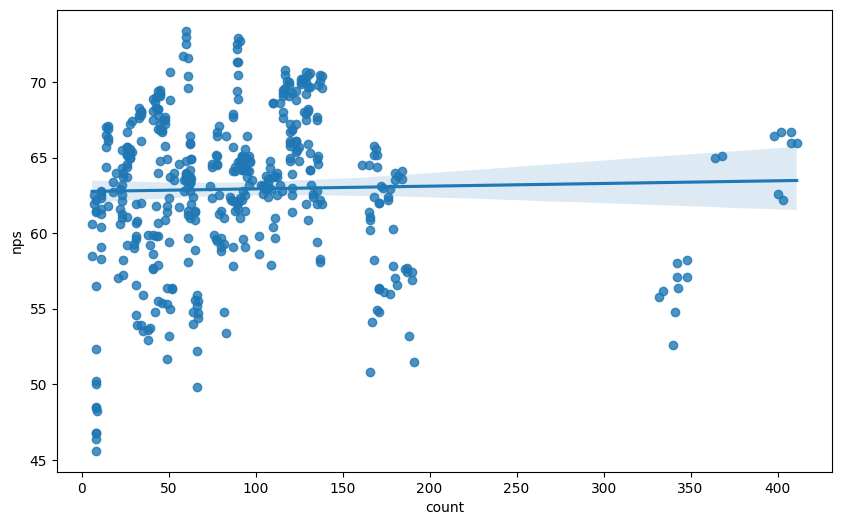

In [153]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(state_nps_count, x='count', y='nps')
plt.show()

In [42]:
response_df = responses[responses.completed_surveys.str.contains('[a-zA-Z]', regex=True) == False]
responses.release_period.value_counts(sort=False)


release_period
2015    4656
2016    4628
2017    4812
2018    4797
2019    4895
2020    4884
2021    4866
2022    4843
2023    4838
Name: count, dtype: int64

In [ ]:
# Interpolate missing MD 2016 data
# New dataframes for MD 2015 and 2017 data
df = state_results.copy()
md_2015 = df[(df.state == 'MD') & (df.release_period == '2015-01-01')]
md_2017 = df[(df.state == 'MD') & (df.release_period == '2017-01-01')]

# Interpolate 2016 data using average of 2015 and 2017 data
md_inter = md_2015.copy()
for col in ['bottom-box_percentage', 'middle-box_percentage', 'top-box_percentage']:
    md_inter[col] = (md_2015[col].values + md_2017[col].values) / 2
md_inter['release_period'] = md_inter['release_period'] + DateOffset(years=1)

# Concatenate interpolated data with original dataframe
state_results = pd.concat([state_results, md_inter], ignore_index=True)
state_results